In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
# !pip install l0bnb
from l0bnb import fit_path


8. In this exercise, we will generate simulated data, and will then use
this data to perform forward and backward stepwise selection.

(a) Create a random number generator and use its normal() method
to generate a predictor X of length n = 100, as well as a noise
vector ϵ of length n = 100.

In [3]:
rng = np.random.default_rng(1)
X = rng.normal(size=100)
eps = rng.normal(loc=0,scale=0.25,size=100)

(b) Generate a response vector Y of length n = 100 according to
the model
Y = β0 + β1X + β2X2 + β3X3 + ϵ,
where β0, β1, β2, and β3 are constants of your choice.

In [4]:
beta_0 = 1.5  # 可以选择其他值
beta_1 = 15
beta_2 = -0.3
beta_3 = 19
Y = beta_0 + beta_1 * X + beta_2 * X**2 + beta_3 * X**3 + eps 
# Y = 1 + X + X**2 + X**3 + eps

In [5]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n 


In [6]:
neg_Cp = partial(nCp, eps)


(c) Use forward stepwise selection in order to select a model containing
the predictors X,X2, . . . ,X10. What is the model obtained
according to Cp? Report the coefficients of the model obtained.

In [7]:
# 首先，创建一个包含X, X^2, ..., X^10的数据框
predictors = {'X': X}
for i in range(2, 11):
    predictors[f'X{i}'] = X**i
df_predictors = pd.DataFrame(predictors)
df_predictors[:4]
design = MS(df_predictors).fit(df_predictors)


In [8]:
# design = MS(X).fit(X)
# terms = pd.DataFrame({'x':X})
# X = MS(['x']).fit_transform(terms)
# X[:4]

In [9]:
# strategy = Stepwise.fixed_steps(model_spec=X,n_steps=10,direction='forward')
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=3)



In [10]:
hitters_MSE = sklearn_selected(OLS,
                               strategy)
hitters_MSE.fit(df_predictors, Y)
hitters_MSE.selected_state_


('X', 'X2', 'X3')

In [11]:
hitters_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp)
hitters_Cp.fit(df_predictors, Y)
hitters_Cp.selected_state_


('X', 'X2', 'X3')

Use forward stepwise selection in order to select a model containing
the predictors X,X^2, . . . ,X^10.  
这里的意思其实是在一个Dateframe含有X,X^2, . . . ,X^10中前序选择

> 这里又GET到新技能👉  
a  
b  
c  
👆{空格} + {空格} + {换行符} = 换行成功 (markdown)  

(d) Repeat (c), using backwards stepwise selection. How does your
answer compare to the results in (c)?

In [12]:
strategy = Stepwise.first_peak(design,
                               direction='backwards',
                               max_terms=3)
                               



In [13]:
hitters_MSE = sklearn_selected(OLS,
                               strategy)
hitters_MSE.fit(df_predictors, Y)
hitters_MSE.selected_state_



('X', 'X2', 'X3')

In [14]:
hitters_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp)
hitters_Cp.fit(df_predictors, Y)
hitters_Cp.selected_state_



('X', 'X2', 'X3')

(e) Now fit a lasso model to the simulated data, again using X,X2,
. . . ,X10 as predictors. Use cross-validation to select the optimal
value of λ. Create plots of the cross-validation error as a function
of λ. Report the resulting coefficient estimates, and discuss the
results obtained.

这里发现这里自己画的是'forward' cross-validation error and train error 的图像  
虽然不是题目要求的  
但是还是在这里保留

In [15]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
full_path = sklearn_selection_path(OLS, strategy)


In [16]:
full_path.fit(df_predictors, Y)
Yhat_in = full_path.predict(df_predictors)
Yhat_in.shape
# Yhat_in[:10]
# Y.shape

(100, 11)

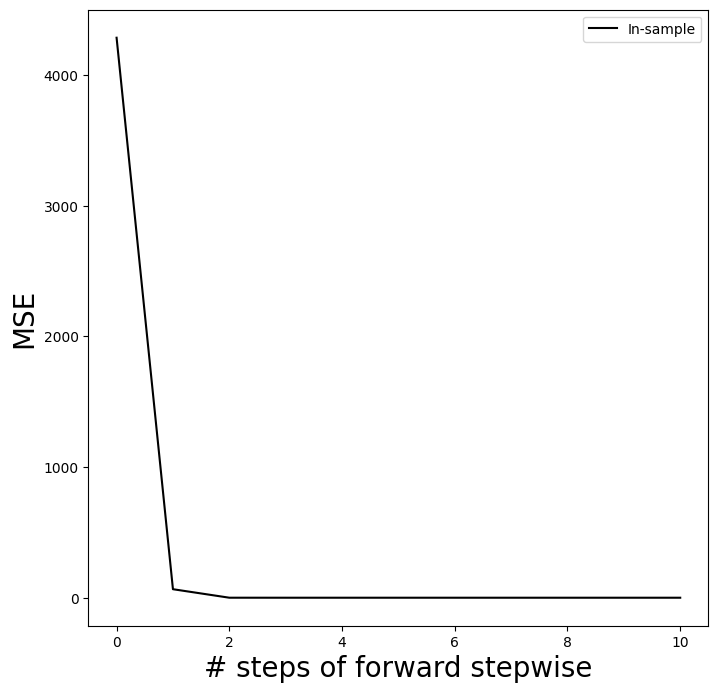

In [17]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
# ax.set_ylim([50000,250000]);


In [18]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,
                                df_predictors,
                                Y,
                                cv=kfold)
Yhat_cv.shape


(100, 11)

In [19]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape
cv_mse

array([[1.63753232e+04, 1.54305709e+03, 6.52539935e+02, 9.15948315e+02,
        2.15081388e+03],
       [7.62882594e+02, 8.87541892e+01, 6.46106132e+01, 6.12296146e+01,
        5.69634835e+01],
       [1.63719724e+00, 7.55821085e-02, 7.84073721e-02, 1.06868379e-01,
        1.46729347e-01],
       [2.64850348e-01, 3.65632501e-02, 3.89480056e-02, 5.11174324e-02,
        7.54675954e-02],
       [2.55038949e-01, 3.63414909e-02, 4.09750669e-02, 4.64144796e-02,
        6.90216795e-02],
       [5.98973786e-01, 3.67821302e-02, 4.33627164e-02, 4.73847813e-02,
        7.20234192e-02],
       [1.84386485e+02, 3.58005901e-02, 4.35281004e-02, 4.80622917e-02,
        7.04666817e-02],
       [2.31627567e+02, 3.84152479e-02, 4.58924897e-02, 4.90751551e-02,
        7.08042016e-02],
       [8.77357094e+01, 3.88189878e-02, 4.51591716e-02, 4.91844422e-02,
        7.14842323e-02],
       [1.92020661e+01, 3.88012995e-02, 4.33899460e-02, 5.05700721e-02,
        7.62755366e-02],
       [3.94081119e+03, 3.5884

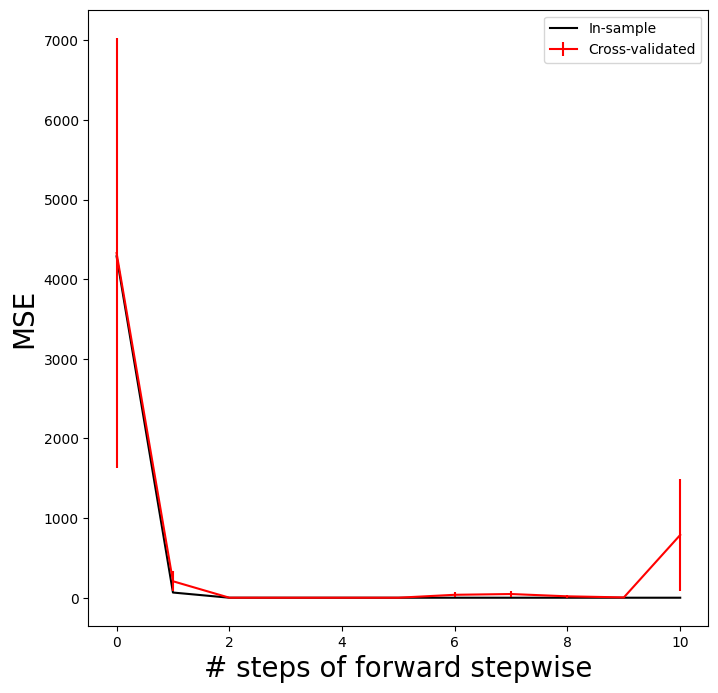

In [20]:
ax.errorbar(np.arange(n_steps), 
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r') # color red
# ax.set_ylim([50000,250000])
ax.legend()
mse_fig


(e) Now fit a lasso model to the simulated data, again using X,X2,
. . . ,X10 as predictors. Use cross-validation to select the optimal
value of λ. Create plots of the cross-validation error as a function
of λ. Report the resulting coefficient estimates, and discuss the
results obtained.

In [21]:
D = design.fit_transform(df_predictors)
D = D.drop('intercept', axis=1)
X = np.asarray(D)



In [22]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape



d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217232.66517634873, tolerance: 43.446689674152
  model = cd_fast.enet_coordinate_descent_gram(
d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objecti

(10, 100)

In [23]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path


,X,X2,X3,X4,X5,X6,X7,X8,X9,X10
negative log(lambda),,,,,,,,,,
-14.239056,0.000036,-0.000022,0.000043,-0.000025,0.000039,-0.000027,0.000035,-0.000027,0.000032,-0.000028
-14.006472,0.000046,-0.000027,0.000054,-0.000032,0.000049,-0.000034,0.000044,-0.000035,0.000041,-0.000035
-13.773887,0.000058,-0.000034,0.000068,-0.000040,0.000062,-0.000042,0.000056,-0.000044,0.000052,-0.000044
-13.541303,0.000073,-0.000043,0.000085,-0.000051,0.000078,-0.000054,0.000071,-0.000055,0.000065,-0.000055
-13.308718,0.000092,-0.000055,0.000108,-0.000064,0.000099,-0.000068,0.000089,-0.000069,0.000082,-0.000070
...,...,...,...,...,...,...,...,...,...,...
7.856458,13.478012,-0.387643,50.858628,-1.279531,7.549224,2.238948,-3.103636,0.747009,-1.742567,-2.350932
8.089042,13.380434,-0.365246,51.288953,-1.199254,7.158080,2.190623,-3.269762,0.654496,-1.698817,-2.485307
8.321626,13.298997,-0.347771,51.654143,-1.126317,6.800196,2.128279,-3.387176,0.585146,-1.639312,-2.569114


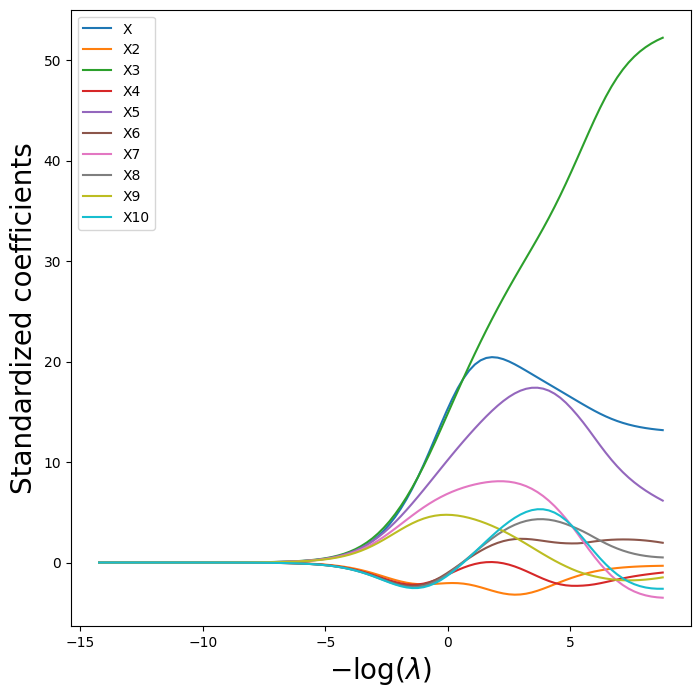

In [24]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');


In [25]:
beta_hat = soln_path.loc[soln_path.index[10]]
lambdas[10], beta_hat



(149225.27161496028,
 X      0.000372
 X2    -0.000220
 X3     0.000435
 X4    -0.000258
 X5     0.000398
 X6    -0.000273
 X7     0.000360
 X8    -0.000280
 X9     0.000333
 X10   -0.000283
 Name: -11.913212333205811, dtype: float64)

In [26]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)



d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.846e+04, tolerance: 4.287e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=1.6762833393275898, l1_ratio=0))])

In [27]:
param_grid = {'ridge__alpha': lambdas}

grid = skm.GridSearchCV(pipe, 
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_



d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.058e+04, tolerance: 1.012e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.992e+05, tolerance: 3.983e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.0004886454882469704, l1_ratio=0))])

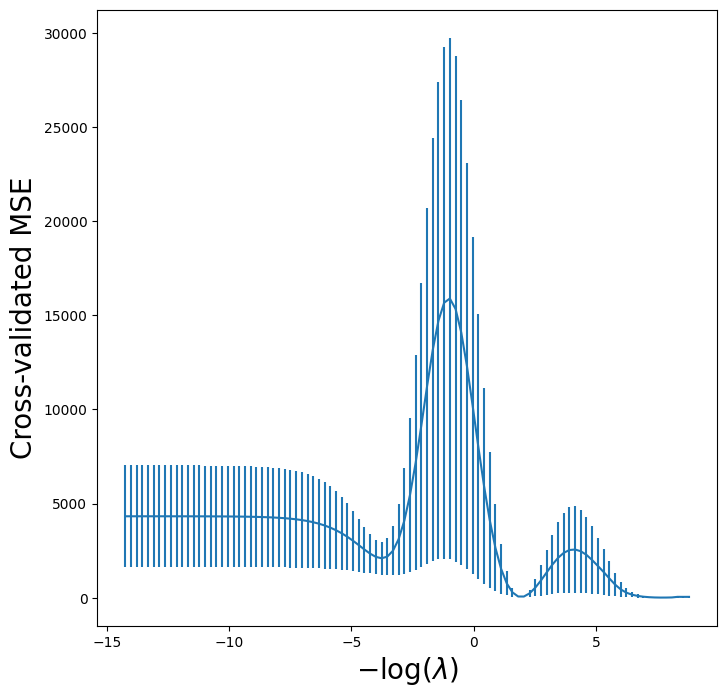

In [28]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
# ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);


In [29]:
grid_r2 = skm.GridSearchCV(pipe, 
                           param_grid,
                           cv=kfold)
grid_r2.fit(X, Y)



d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.058e+04, tolerance: 1.012e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.992e+05, tolerance: 3.983e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=1.6762833393275898,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([1.52736695e+06, 1.21041219e+06, 9.59230957e+05, 7.60174129e+05,
       6.02424997e+05, 4.77411508e+05, 3.78340455e+05, 2.99828341e+05,
       2.37608832e+05, 1.883...
       3.21496102e-02, 2.54780163e-02, 2.01908922e-02, 1.60009367e-02,
       1.26804687e-02, 1.00490546e-02, 7.96370392e-03, 6.31109917e-03,
       5.00143816e-03, 3.96355421e-03, 3.14104893e-03, 2.48922756e-03,
       1.97267027e-03, 1.56330745e-03, 1.23889442e-03, 9.81802642e-04,
       7.78061803e-04, 6.16600673e-04, 4.88645488e-04, 3.87243193e-04,
       3.06883608e-04, 2.43200011e-04, 1.92731850e-04, 1.52736695e-04])})

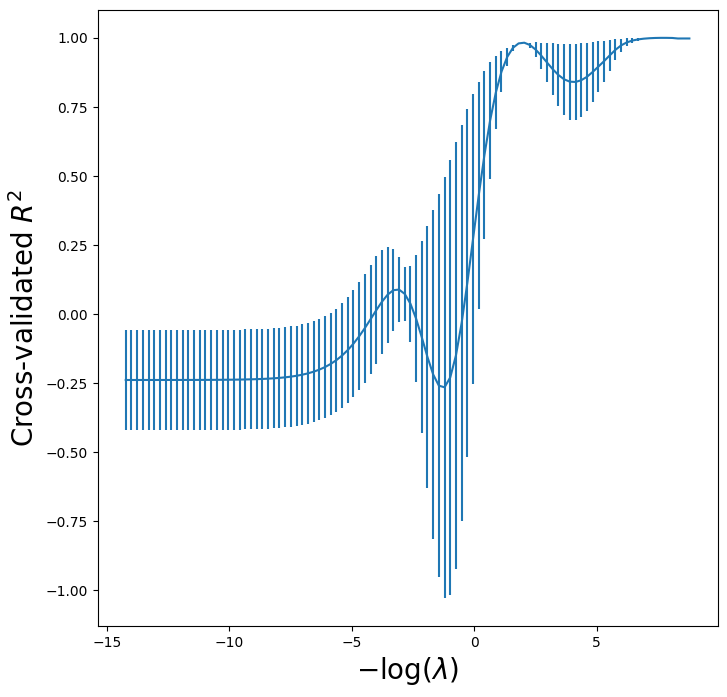

In [30]:
r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20);


(f) Now generate a response vector `Y` according to the model  
<center>Y = β0 + β7X7 + ϵ, </center>  

and perform forward stepwise selection and the lasso. Discuss
the results obtained.

---

`MARKDOWN编辑测试👇`

> 那还有什么常见的HTML标签，在markdown使用

<pre>
def hello():
    print('hello')
</pre>

---

In [31]:
rng = np.random.default_rng(1)
X = rng.normal(size=100)
eps = rng.normal(loc=0,scale=0.25,size=100)

In [32]:
beta_7 = 7

Y = beta_0 + beta_7 * X**7 + eps

In [33]:
# 首先，创建一个包含X, X^2, ..., X^10的数据框
predictors = {'X': X}
for i in range(2, 11):
    predictors[f'X{i}'] = X**i
df_predictors = pd.DataFrame(predictors)
df_predictors[:4]
design = MS(df_predictors).fit(df_predictors)



In [34]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
full_path = sklearn_selection_path(OLS, strategy)



In [35]:
full_path.fit(df_predictors, Y)
Yhat_in = full_path.predict(df_predictors)
Yhat_in.shape

(100, 11)

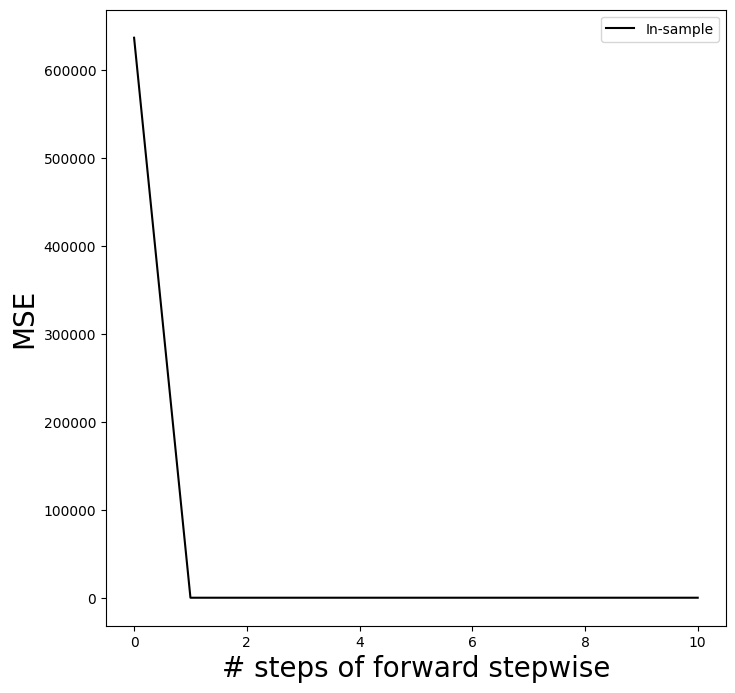

In [36]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps),
        insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE',
              fontsize=20)
ax.set_xlabel('# steps of forward stepwise',
              fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
# ax.set_ylim([50000,250000]);



In [37]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path,
                                df_predictors,
                                Y,
                                cv=kfold)
Yhat_cv.shape



(100, 11)

In [38]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
    cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape


(11, 5)

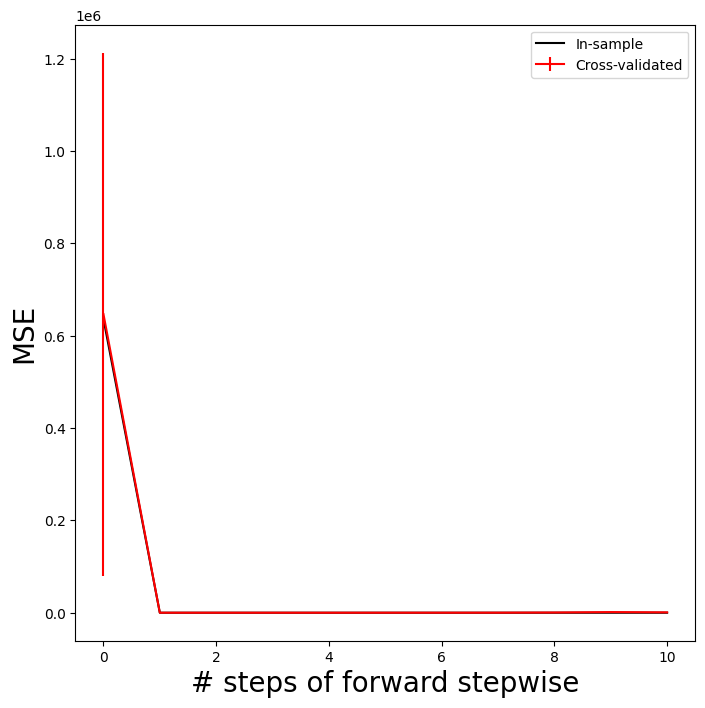

In [39]:
ax.errorbar(np.arange(n_steps), 
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(K),
            label='Cross-validated',
            c='r') # color red
# ax.set_ylim([50000,250000])
ax.legend()
mse_fig



In [40]:
D = design.fit_transform(df_predictors)
D = D.drop('intercept', axis=1)
X = np.asarray(D)



In [41]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape



d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32187321.635784723, tolerance: 6437.839375833047
  model = cd_fast.enet_coordinate_descent_gram(
d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objec

(10, 100)

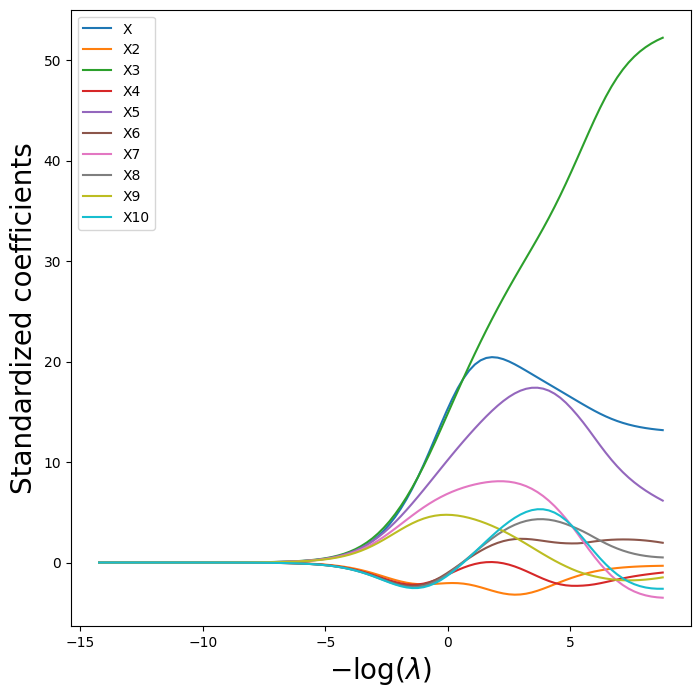

In [42]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');



In [43]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True,  with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)



d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.927e+05, tolerance: 6.364e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.1375767925848001, l1_ratio=0))])

In [44]:
param_grid = {'ridge__alpha': lambdas}

grid = skm.GridSearchCV(pipe, 
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_



d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.544e+05, tolerance: 5.088e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.172e+07, tolerance: 6.345e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNet(alpha=4.0104365059798554e-05, l1_ratio=0))])

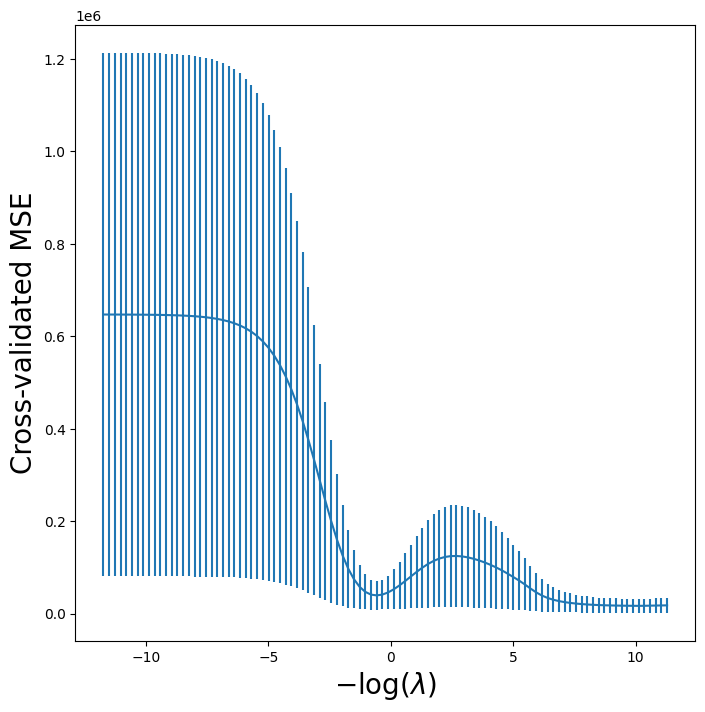

In [45]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
# ax.set_ylim([50000,250000])
# ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);



In [46]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas, 
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)



d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254409.26450467802, tolerance: 50.882180093703774
  model = cd_fast.enet_coordinate_descent_gram(
d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
d:\anaconda3\envs\ISLP3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Obje

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([1.25354850e+05, 9.93415745e+04, 7.87264989e+04, 6.23894040e+04,
       4.94425357e+04, 3.91823640e+04, 3.10513534e+04, 2.46076665e+04,
       1.95011549e+04, 1.54543317e+04, 1.22472936e+04, 9.70577074e+03,
       7.69165733e+03, 6.09550689e+03, 4.83058497e+03, 3.82815598e+03,
       3.03374814e+03, 2.40419352e+03,...
       1.04071798e-03, 8.24751204e-04, 6.53601224e-04, 5.17967793e-04,
       4.10480618e-04, 3.25298869e-04, 2.57793791e-04, 2.04297171e-04,
       1.61902014e-04, 1.28304577e-04, 1.01679183e-04, 8.05790138e-05,
       6.38574904e-05, 5.06059691e-05, 4.01043651e-05, 3.17820235e-05,
       2.51867101e-05, 1.99600370e-05, 1.58179880e-05, 1.25354850e-05]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

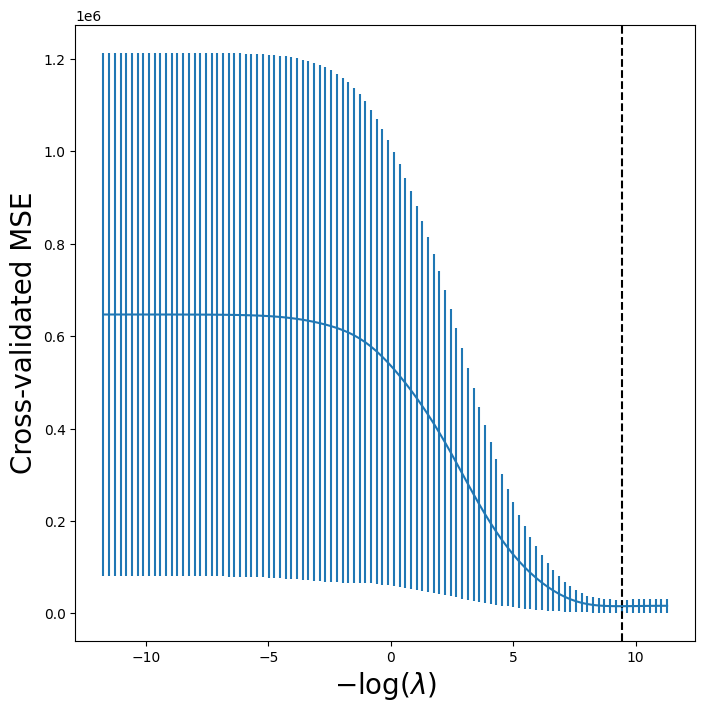

In [47]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
# ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);



9. In this exercise, we will predict the number of applications received
using the other variables in the `College` data set.

(a) Split the data set into a training set and a test set.

(b) Fit a linear model using least squares on the training set, and
report the test error obtained.

In [ ]:
(c) Fit a ridge regression model on the training set, with λ chosen
by cross-validation. Report the test error obtained.